In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bs4 as bs
import requests
import geocoder
from sklearn.cluster import KMeans 
import folium
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors


# Getting the Data

## Reading in the page, and Pulling the Table from the HTML code

In [2]:
wiki_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

page_data = requests.get(wiki_url, timeout = 5)

page_content = bs.BeautifulSoup(page_data.content, "html.parser")


data_table = page_content.find('table',{'class':'wikitable sortable'})


## Selecting the Variable Names From the Table

In [3]:
columns = data_table.find_all('th')

In [4]:
variable_names = []

for col in columns: 
    
    variable_names.append(col.text)




In [5]:
variable_names ## Column names will need cleaning

['Postcode', 'Borough', 'Neighbourhood\n']

## Selecting and Cleaning the Rows from the Table

In [6]:
raw_rows = data_table.find_all('tr')[0:]
parsed_rows = []

In [7]:
for r in raw_rows:
    
    parsed_rows.append(r.text)
    
    

In [8]:
no_newline_rows = [r.replace('\n',',') for r in parsed_rows] ## Replacing Newlines 

In [9]:
parsed_into_rows = [nnr.split(',') for nnr in no_newline_rows] ## Parsing Text Strings into Rows

In [10]:
parsed_into_rows[0] # An example of what these elements look like

['', 'Postcode', 'Borough', 'Neighbourhood', '']

In [11]:
final_data = []

for pr in parsed_into_rows: ## Removing Empty Elements
    
    final_data.append([t for t in pr if t != ""])

## Formatting into Pandas DataFrame and Cleaning Columns

In [12]:
column_names = final_data[0]

In [13]:
first_column = [final_data[i][0] for i in range(1,len(final_data[1:])+1)] ## Creaing the 
second_column = [final_data[i][1] for i in range(1,len(final_data[1:])+1)]
third_column = [final_data[i][2] for i in range(1,len(final_data[1:])+1)]

In [14]:
pd_dict = {column_names[0]:first_column, column_names[1]: second_column, column_names[2]: third_column}

In [15]:
full_neighborhood_data = pd.DataFrame(pd_dict, columns = column_names)

In [16]:
bad_value = full_neighborhood_data.Borough[0] ## Removing 'Not assigned' boroughs

In [17]:
data_with_good_buroughs = full_neighborhood_data.loc[full_neighborhood_data['Borough'] != bad_value,:]

In [18]:
data_with_good_buroughs.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


## Aggregating Postcodes with Multiple Neighborhoods

In [19]:
Postcode_counts = data_with_good_buroughs.Postcode.value_counts() 
unique_postcodes = list(Postcode_counts.index)## Identifying post codes with multiple neighbrhoods

In [20]:
new_rows = [] ## Rows for our final data set

for m in unique_postcodes:
    
    data_this_post_code = data_with_good_buroughs.loc[data_with_good_buroughs.Postcode == m,:] 
    ## Data for a given post code
    
    neighborhoods = list(data_this_post_code.loc[:,'Neighbourhood']) ## Neighborhoods in that post code
    
    counted = 0 ## A way of dealing with 'Not assigned' neighborhoods, and making sure when correcting for this
    ## We don't duplicate the value of the borough (so each neighborhood name only appears once)
    
    for i in range(len(neighborhoods)):
        
        if neighborhoods[i] == bad_value: ## If "Not assigned", give it the borough name
            
            ## Makes sure that we don't but borough name in more than once,
                     ##           in case a given borough has multiple missing neighborhoods.
            
            if counted == 0: 
                
                            ## Makes sure that we don't but borough name in more than once,
                            ##  in case a given borough has multiple missing neighborhoods.
                 
                neighborhoods[i] = list(data_this_post_code.loc[:,'Borough'])[0]
                
                counted +=1
            
    new_rows.append(', '.join(neighborhoods)) ## Joining all neighborhoods together 
       
            
                     
        



## Creating Final data

In [21]:
postcodes_and_neighborhoods = pd.DataFrame({'Postcode':unique_postcodes, 'Neighbourhood':new_rows},
                                          columns = ('Postcode', 'Neighbourhood'))  

## Data With Postcodes and Neighborhoods

In [22]:
postcodes_and_boroughs = data_with_good_buroughs.loc[:,['Postcode','Borough']].drop_duplicates()

## Data with Unique Postcodes and Boroughs

In [23]:
final_neighborhood_data = postcodes_and_boroughs.merge(postcodes_and_neighborhoods,how = 'inner' ,on = 'Postcode')

## Inner joining the two previous data sets to obtain the final data set

In [24]:
neighborhoods_to_look_at = ['M5G','M2H','M4B','M1J','M4G','M4M','M1R','M9V','M9L','M5V','M1B','M5A']

final_neighborhood_data.loc[final_neighborhood_data['Postcode'].isin(neighborhoods_to_look_at),:]

## Presenting the neighborhoods that are listed in the assignment sumbmission image for verification.
## The neighborhoods will appear in a different order than shown on that image, but they correspond 
## to the correct borough and postal code.''' 

,Postcode,Borough,Neighbourhood
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
6,M1B,Scarborough,"Rouge, Malvern"
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
23,M4G,East York,Leaside
24,M5G,Downtown Toronto,Central Bay Street
27,M2H,North York,Hillcrest Village
32,M1J,Scarborough,Scarborough Village
50,M9L,North York,Humber Summit
54,M4M,East Toronto,Studio District
71,M1R,Scarborough,"Maryvale, Wexford"


In [25]:
final_neighborhood_data.shape ## Dimensions of our final data set

(103, 3)

# Geocoding the Data With Provided .csv

In [26]:
lat_lon_data = pd.read_csv('Geospatial_Coordinates.csv')
lat_lon_data.columns = ['Postcode','Latitude','Longitude']

In [27]:
geocoded_neighborhood_data = final_neighborhood_data.merge(lat_lon_data,how = 'inner' ,on = 'Postcode')

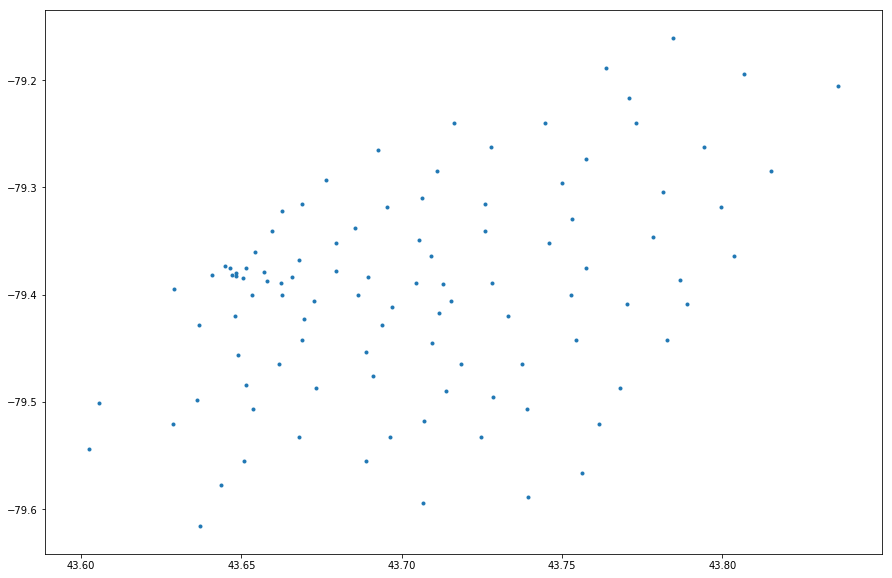

In [28]:
plt.figure(figsize=(15, 10))
plt.scatter(geocoded_neighborhood_data.loc[:,'Latitude'], geocoded_neighborhood_data.loc[:,'Longitude'], marker='.')

# Exploring and Clustering the Neighborhoods

## Initial Map of Neighborhoods

In [29]:
toronto_latitude= 43.6532

toronto_longitude = -79.3832

map_toronto = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(geocoded_neighborhood_data['Latitude'], geocoded_neighborhood_data['Longitude'], 
                                           geocoded_neighborhood_data['Borough'], geocoded_neighborhood_data['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

## Analysis of Neighborhoods for Boroughs with word 'Toronto' in Them

In [30]:
neighborhoods_in_toronto = ['Toronto' in t for t in geocoded_neighborhood_data['Borough']]


toronto_data = geocoded_neighborhood_data.loc[neighborhoods_in_toronto,:].reset_index()


toronto_data.shape

(38, 6)

In [31]:
toronto_data.head()

,index,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
1,9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
2,15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,19,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [32]:
toronto_latitude= 43.6532

toronto_longitude = -79.3832

map_toronto = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], 
                                           toronto_data['Borough'], toronto_data['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

In [33]:
toronto_data.head(5)

,index,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
1,9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
2,15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,19,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


### Pulling External Data for These Neighborhoods

In [34]:
CLIENT_ID = 'YUU0NVDSIOGUCYMC0B0ICX50TC1Z1B0X3VVZLQKCLGQLHDY2' # your Foursquare ID
CLIENT_SECRET = 'T1PRGFNN21DILJN4G5DCHD30RWT5FK02Z4SXV0ZJNWFD5W25' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
RADIUS = 500

In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
borourghs_with_toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
The Danforth West, Riverdale
Design Exchange, Toronto Dominion Centre
Brockton, Exhibition Place, Parkdale Village
The Beaches West, India Bazaar
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North, Forest Hill West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
Harbord, University of Toronto
Runnymede, Swansea
Moore Park, Summerhill East
Chinatown, Grange Park, Kensington Market
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown, St. James Town
Fir

In [37]:
# borourghs_with_toronto_venues.to_csv('Toronto_Venue_Data.csv') ## To save data to call only has to be made once

In [38]:
## Encoding Venues, as in New York Analysis
one_hot_encoded_venues = pd.get_dummies(borourghs_with_toronto_venues['Venue Category'])

In [39]:
one_hot_encoded_venues.insert(loc =0, column = 'Neighbourhood',  ## Adding Neighbourhood column
                              value = borourghs_with_toronto_venues['Neighborhood'])

In [40]:
one_hot_encoded_venues.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:

venue_data_for_k_means = one_hot_encoded_venues.groupby('Neighbourhood').mean().reset_index()

#### Pulling Top Five Most Prevalent Venues for Each Neighborhood

In [42]:
num_top_venues = 5

for hood in venue_data_for_k_means['Neighbourhood']:
    print("----"+hood+"----")
    temp = venue_data_for_k_means[venue_data_for_k_means['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.07
1                 Café  0.06
2  American Restaurant  0.04
3      Thai Restaurant  0.04
4           Steakhouse  0.04


----Berczy Park----
          venue  freq
0   Coffee Shop  0.09
1  Cocktail Bar  0.06
2    Steakhouse  0.04
3    Restaurant  0.04
4      Beer Bar  0.04


----Brockton, Exhibition Place, Parkdale Village----
                  venue  freq
0           Coffee Shop  0.14
1        Breakfast Spot  0.10
2                  Café  0.10
3         Burrito Place  0.05
4  Caribbean Restaurant  0.05


----Business reply mail Processing Centre969 Eastern----
              venue  freq
0       Yoga Studio  0.06
1     Auto Workshop  0.06
2        Comic Shop  0.06
3              Park  0.06
4  Recording Studio  0.06


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0   Airport Service  0.14
1  Airport Terminal 

#### Pulling Top Ten Most Prevalent Venues for Each Neighborhood

In [43]:
num_top_venues = 10

neighs = []

pop_venues = []

for hood in venue_data_for_k_means['Neighbourhood']:
    temp = venue_data_for_k_means[venue_data_for_k_means['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    neighs.append(hood)
    vens_and_props = (temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    pop_venues.append(list(vens_and_props['venue']))
    



In [44]:
column_names = (['1st Most Common Value', '2nd Most Common Value','3rd Most Common Value']+
               [str(i)+'th Most Common Value' for i in range(4,11)])

data_dict = dict(zip(venue_data_for_k_means['Neighbourhood'], pop_venues))
pop_venue_data = pd.DataFrame(data_dict).transpose()

pop_venue_data.columns = column_names


pop_venue_data.head()

,1st Most Common Value,2nd Most Common Value,3rd Most Common Value,4th Most Common Value,5th Most Common Value,6th Most Common Value,7th Most Common Value,8th Most Common Value,9th Most Common Value,10th Most Common Value
"Adelaide, King, Richmond",Coffee Shop,Café,American Restaurant,Thai Restaurant,Steakhouse,Bar,Cosmetics Shop,Gym,Restaurant,Hotel
Berczy Park,Coffee Shop,Cocktail Bar,Steakhouse,Restaurant,Beer Bar,Café,Cheese Shop,Seafood Restaurant,Bakery,Farmers Market
"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Breakfast Spot,Café,Burrito Place,Caribbean Restaurant,Bar,Furniture / Home Store,Climbing Gym,Stadium,Falafel Restaurant
Business reply mail Processing Centre969 Eastern,Yoga Studio,Auto Workshop,Comic Shop,Park,Recording Studio,Restaurant,Butcher,Burrito Place,Farmers Market,Brewery
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",Airport Service,Airport Terminal,Airport Lounge,Harbor / Marina,Sculpture Garden,Boutique,Boat or Ferry,Plane,Airport Gate,Airport


There are relationships between the neighbohoods, and which venues are most popular there. For example, one of the neighborhoods contains a lot venues relating to airports, while another mainly contains restaurants and other food establishments (Berczy park). Still, another contains trendy venues (a climbing gym, a falafel restaurant, etc.). 

### K-Means Clustering of Neighborhoods Based on Venues

In [45]:
# Assuming 7 Clusters
kclusters = 7

toronto_grouped_clustering = venue_data_for_k_means.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int32)

In [46]:
toronto_merged = pop_venue_data

# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_
toronto_merged.index.name = 'Neighbourhood'
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood

toronto_merged = toronto_merged.join(toronto_data.set_index('Neighbourhood'))

# manhattan_merged.head() # check the last columns!


toronto_merged




,1st Most Common Value,2nd Most Common Value,3rd Most Common Value,4th Most Common Value,5th Most Common Value,6th Most Common Value,7th Most Common Value,8th Most Common Value,9th Most Common Value,10th Most Common Value,Cluster Labels,index,Postcode,Borough,Latitude,Longitude
Neighbourhood,,,,,,,,,,,,,,,,
"Adelaide, King, Richmond",Coffee Shop,Café,American Restaurant,Thai Restaurant,Steakhouse,Bar,Cosmetics Shop,Gym,Restaurant,Hotel,0,30,M5H,Downtown Toronto,43.650571,-79.384568
Berczy Park,Coffee Shop,Cocktail Bar,Steakhouse,Restaurant,Beer Bar,Café,Cheese Shop,Seafood Restaurant,Bakery,Farmers Market,0,20,M5E,Downtown Toronto,43.644771,-79.373306
"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Breakfast Spot,Café,Burrito Place,Caribbean Restaurant,Bar,Furniture / Home Store,Climbing Gym,Stadium,Falafel Restaurant,6,43,M6K,West Toronto,43.636847,-79.428191
Business reply mail Processing Centre969 Eastern,Yoga Studio,Auto Workshop,Comic Shop,Park,Recording Studio,Restaurant,Butcher,Burrito Place,Farmers Market,Brewery,6,100,M7Y,East Toronto,43.662744,-79.321558
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",Airport Service,Airport Terminal,Airport Lounge,Harbor / Marina,Sculpture Garden,Boutique,Boat or Ferry,Plane,Airport Gate,Airport,6,87,M5V,Downtown Toronto,43.628947,-79.394420
"Cabbagetown, St. James Town",Coffee Shop,Restaurant,Chinese Restaurant,Pizza Place,Indian Restaurant,Bakery,Italian Restaurant,Pub,Park,Café,6,96,M4X,Downtown Toronto,43.667967,-79.367675
Central Bay Street,Coffee Shop,Café,Italian Restaurant,Burger Joint,Japanese Restaurant,Sandwich Place,Bar,Bubble Tea Shop,Falafel Restaurant,Spa,6,24,M5G,Downtown Toronto,43.657952,-79.387383
"Chinatown, Grange Park, Kensington Market",Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Bar,Mexican Restaurant,Vietnamese Restaurant,Bakery,Coffee Shop,Dumpling Restaurant,Burger Joint,6,84,M5T,Downtown Toronto,43.653206,-79.400049
Christie,Café,Grocery Store,Park,Baby Store,Restaurant,Convenience Store,Athletics & Sports,Coffee Shop,Nightclub,Diner,6,25,M6G,Downtown Toronto,43.669542,-79.422564


In [47]:
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=12)


# set color scheme for the clusters

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged.index, 
                                  toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The Above plot exhibits some interesting geographical trends. There is one main cluster (the orange one), with a small red cluster close to the bay. 